# Exploring the Legacy of Redlining

This executable notebook provides an opening example to illustrate a cloud-native workflow. 
Pedagogy research emphasizes the importance of "playing the whole game" before breaking down every pitch and hit.
We intentionally focus on powerful high-level tools (STAC API, COGs, datacubes) to illustrate how a few chunks of
code can perform a task that would be far slower and more verbose in a traditional file-based, download-first workflow.
Note the close parallels between R and Python syntax. This arises because both languages wrap the same underlying 
tools (the STAC API and GDAL warper) and handle many of the nuisances of spatial data -- from re-projections and
resampling to mosaic tiles -- without us noticing.

In [1]:
from pystac_client import Client
import odc.stac
import pystac_client
import rioxarray
import os
# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

## Data discovery

<!--
Large geospatial data comes in many different formats and is frequently divided into many individual files or "assets" which may represent different points in space, time, sensor bands or variables. Many users are familiar with file-based workflows, where each file type is read into the computational environment by a specific tool and that workflows proceed file-by-file. However, the same data can be represented in many different formats (ncdf or tiff, say) and subdivided in different ways. Importantly, the file-based-divisions often do not reflect the way a user might want to work with the data.  For instance, a NASA ncdf product may provide sea-surface-temperature as one file per day, with each file covering the entire global extent, while a user wants to examine trends in the data over time but only in a certain regional area. In such cases, it is inefficient to download data for the whole globe over many files.  Just as end-users in high level languages are not expected to manage very low-level concepts like memory block sizes, geospatial data scientists need not worry about these file serialization details when they have good high-level abstractions that can do it for them.  
-->

The first step in many workflows involves discovering individual spatial data files covering the space, time, and variables of interest. Here we use a [STAC](https://stacspec.org/en) Catalog API to recover a list of candidate data. 
We dig deeper into how this works and what it returns in later recipes. This example searches for images in a lon-lat bounding box from a collection of Cloud-Optimized-GeoTIFF (COG) images taken by Sentinel2 satellite mission.
This function will not download any imagery, it merely gives us a list of metadata about available images, including the access URLs.


In [2]:
box = [-122.51, 37.71, -122.36, 37.81]
items = (
  Client.
  open("https://earth-search.aws.element84.com/v1").
  search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2022-06-01/2022-08-01",
    query={"eo:cloud_cover": {"lt": 20}}).
  item_collection()
)


We pass this list of images to a high-level utilty (`gdalcubes` in R, `odc.stac` in python) that will do all of the heavy lifting.  Using the URLs and metadata provided by STAC, 
these functions can extract only our data of interest (given by the bounding box) without downloading unnecessary regions or bands. While streaming the data, these functions
will also reproject it into the desired coordinate reference system -- (an often costly operation to perform in R) and can potentially resample or aggregate the data to a desired 
spatial resolution. (The R code will also resample from images in overlapping areas to replace pixels masked by clouds)


In [3]:
data = odc.stac.load(
    items,
    crs="EPSG:32610",
    bands=["nir08", "red"],
    bbox=box
)
# For some reason, requesting reprojection in EPSG:4326 gives only empty values

We can do arbitrary calculations on this data as well. Here we calculate NDVI, a widely used measure of greenness that can be used to determine vegetation cover. 
(Note that the R example uses lazy evaluation, and can thus perform these calculations while streaming)

In [4]:
ndvi = (((data.nir08 - data.red) / (data.red + data.nir08)).
        resample(time="MS").
        median("time", keep_attrs=True).
        compute()
)

# mask out bad pixels
ndvi = ndvi.where(ndvi <= 1)

In [5]:
ndvi

<xarray.DataArray (time: 1, y: 1118, x: 1329)> Size: 12MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 9kB 4.185e+06 4.185e+06 ... 4.174e+06 4.174e+06
  * x            (x) float64 11kB 5.431e+05 5.431e+05 ... 5.564e+05 5.564e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 8B 2022-06-01

And we peek at the result [^1].  The long rectangle of Golden Gate Park is clearly visible in the North-West:

[^1]: We will introduce a richer set of tools in a moment.  

In [6]:
ndvi.plot()

We reproject this data into web mercator projection (longitude/latitude coordinates, EPSG:4326) and serialize as a Cloud Optimized Geotiff (COG) file using `rioxarray`, which will make this data useful to us in the future. While we could simply write the file to a path on the local disk (e.g. `dest = "sf-ndvi.tif"`), the code below exploits the virtual filesystem interface (VSI) to write the file directly to a cloud object store (which requires access to necessary environmental variables). 

In [7]:
# assumes configuration
bucket = "cboettig"
path = "espm-157/sf-ndvi.tif"
dest = f"/vsis3/{bucket}/{path}"

(   ndvi.
    rio.reproject("EPSG:4326").
    rio.to_raster(dest, driver="COG")   
)

CPLE_AWSError: Invalid AWS response: <html> <head><title>502 Bad Gateway</title></head> <body> <center><h1>502 Bad Gateway</h1></center> </body> </html> 

Because we have written to a publicly readable bucket, our COG is now accessible without authentication using a normal `https` address.  This will be convenient later in constructing interactive maps.  

In [8]:
endpoint = os.environ["AWS_S3_ENDPOINT"]
public_url = f"https://{endpoint}/{bucket}/{path}"


# From NDVI to Environmental Justice

We examine the present-day impact of historic "red-lining" of US cities during the Great Depression using data from the [Mapping Inequality](https://dsl.richmond.edu/panorama/redlining) project.  All though this racist practice was banned by federal law under the Fair Housing Act of 1968, the systemic scars of that practice are still so deeply etched on our landscape that the remain visible from space -- "red-lined" areas (graded "D" under the racist HOLC scheme) show systematically lower greenness than predominately-white neighborhoods (Grade "A").  Trees provide many benefits, from mitigating urban heat to biodiversity, real-estate value, to health.




## Spatial Vector Formats

While our satellite imagery data uses raster file formats such as COG, cartographic features such as polygons, lines or points are represented in vector formats. `duckdb` provides a scalable way to read and manipulate very large datasets from databases, tabular files (like csv or parquet) and geospatial vector objects (e.g. shapefiles, gpkg, geojson, geoparquet).  

In [9]:

import ibis
from ibis import _
con = ibis.duckdb.connect()

city = (
    con
    .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
    .filter(_.city == "San Francisco", _.residential)
    .execute()
    .set_crs("EPSG:4326")
   )

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


## Zonal statistics 

In addition to large scale raster data such as satellite imagery, the analysis of vector shapes such as polygons showing administrative regions is a central component of spatial analysis, and particularly important to spatial social sciences. The red-lined areas of the 1930s are one example of spatial vectors. One common operation is to summarise the values of all pixels falling within a given polygon, e.g. computing the average greenness (NDVI) 

In [10]:
from exactextract import exact_extract
exact_extract(dest, 
              city, 
              ["mean"], 
              include_geom = True,
              include_cols = ["label", "grade", "city", "fill"],
              output_options = {"filename": "out.parquet"},
              output="gdal") # alternatively use "pandas" for (geo)pandas output

We plot the underlying NDVI as well as the average NDVI of each polygon, along with it's textual grade.  Note that "A" grades tend to be darkest green (high NDVI) while "D" grades are frequently the least green.  (Regions not zoned for housing at the time of the 1937 housing assessment are not displayed as polygons.)

In [11]:
import leafmap.maplibregl as leafmap

m = leafmap.Map() # set style="liberty" for different basemap
m.add_cog_layer(public_url, name = "NDVI", opacity = 0.7) # set palette="greens" for color
m.add_gdf(city, "fill", paint = {"fill-color": ["get", "fill"], "fill-opacity": 0.5})
m.add_layer_control()
m



Map(height='600px', map_options={'bearing': 0, 'center': (0, 20), 'pitch': 0, 'style': 'https://basemaps.carto…

Are historically redlined areas still less green?


In [12]:

mean_ndvi = (con
 .read_parquet("out.parquet")
 .rename(ndvi="mean")
 .group_by(_.grade)
 .agg(mean_ndvi = _.ndvi.mean())
 .order_by(_.mean_ndvi.desc())
 .execute()
)
mean_ndvi

,grade,mean_ndvi
0,A,0.338100
1,B,0.247741
2,C,0.236526
3,D,0.232238


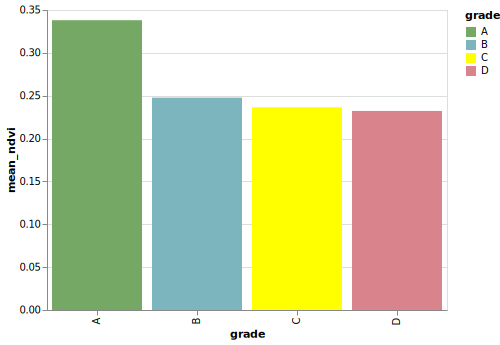

In [13]:
import altair as alt

# grab the color scales from the data, for fun
color_map = con.read_parquet("out.parquet").select("grade", "fill").distinct().order_by(_.grade).execute()
colors = alt.Scale(domain = color_map["grade"], range = color_map["fill"])

# Create an Altair chart
chart = alt.Chart(mean_ndvi).mark_bar().encode(
    x='grade',
    y='mean_ndvi:Q',
    color=alt.Color('grade', scale=colors)
).properties(width=400)

# display as SVG for compatibility with github ipynb rendering
from IPython.display import SVG
chart.save('temp.svg')
SVG('temp.svg')